<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hyrid-input" data-toc-modified-id="Hyrid-input-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hyrid input</a></span><ul class="toc-item"><li><span><a href="#A-problem-without-hybrid-stimulation" data-toc-modified-id="A-problem-without-hybrid-stimulation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>A problem without hybrid stimulation</a></span></li><li><span><a href="#A-hybrid-stimulation" data-toc-modified-id="A-hybrid-stimulation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>A hybrid stimulation</a></span></li><li><span><a href="#Total-integrals" data-toc-modified-id="Total-integrals-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Total integrals</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib
#matplotlib.use('Qt5Agg') # uncomment this for visualizing in a new window
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition, mark_inset)
from matplotlib.offsetbox import AnchoredText

import numpy as np
from dolfin import *
from multiphenics import *

In [2]:
import dolfin # just for printing the version

print(matplotlib.__version__)
print(np.__version__)
print(dolfin.__version__)

3.0.3
1.19.5
2019.2.0.dev0


In [3]:
# some global parameters
tol = DOLFIN_EPS
degree = 2    # degree of Lagrange finite elements
sigma0 = 1    # tissue conductivity (unitless)
z = 1e-2      # electrode-tissue impedance (unitless)
N = 4         # number of contacts on the electrode
f0 = 1e-15    # a zero forcing (optional - added for stability)

# Hyrid stimulation
In theory it is possible to use both  current and voltage for stimulation. Here we show an example of this. Nothing has to be changed except the boundary condition type. Here we demonstrate how this can be done. 

For the sake of clarity we run once using single-type stimulation and once hybrid. In general, everything is similar to the main notebook, except the BC. So let's get down to business.

In [4]:
# Mesh selection
mesh_name = 'DBS'
path = './meshes/'+mesh_name+'/'
mesh = Mesh(path+mesh_name+".xml")
subdomains = MeshFunction("size_t", mesh, path+mesh_name+"_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, path+mesh_name+"_facet_region.xml")
cnt_id = 25 # this is the id of first contact in the mesh

## uncomment the following lines if you want to view in Paraview
# File(path+mesh_name+"_boundaries.pvd") << boundaries
# File(path+mesh_name+"_subdomains.pvd") << subdomains

In [5]:
# function space def.
V = FunctionSpace(mesh, "Lagrange", degree)
R = FunctionSpace(mesh, "R", 0) # global constant
W = BlockFunctionSpace([V]+[R]*N)#, restrict=[None]+ contacts)

x = SpatialCoordinate(mesh)
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)

# we need the area of each contact on the weak form
areas = [assemble(2*pi*x[0]*dot(n,n)*ds(cnt_id+i)) for i in range(N)] 

# conductivity: this time it's just a constant 
sigma = sigma0

# forcing
f= Constant(f0)

## Single type stimulation
Let's choose the same BCs as before: Voltages on C0 and C2.

In [6]:
# BC  
input_types = ['I' for i in range(N)]
inputs = [Constant(0) for i in range(N)] 

# fixed potential on C0 and C2
input_types[0]='V'
input_types[2]='V'
inputs[0] = Constant(1)
inputs[2] = Constant(0)

# the exterior boundary conditions are easy.
bc_bottom = DirichletBC(W.sub(0), Constant(0), boundaries, 3) # bottom

# this makes a block BCs object (note the emptyness of the contacts' block)
bcs = BlockDirichletBC([[bc_bottom]]+
                       [[], [], [], []])

In [7]:
# WEAK FORM
# define the mixed elements
u_mix = BlockTrialFunction(W)
v_mix = BlockTestFunction(W)

# split the mixed elemetns
u_spl = block_split(u_mix)
v_spl = block_split(v_mix)

# RHS
a_00 = 2*pi*x[0]*inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
a_0n = []
a_n0 = []
a_nn = []
for i in range(N):
    a_00 += 2*pi*x[0]*dot(u_spl[0],v_spl[0])/(z)*ds(cnt_id+i)
    if input_types[i]=='I':
        a_0n.append(-2*pi*x[0]*dot(u_spl[0], v_spl[i+1])/(z)*ds(cnt_id+i))
        a_n0.append(-2*pi*x[0]*dot(u_spl[i+1], v_spl[0])/(z)*ds(cnt_id+i))
        a_nn.append(+2*pi*x[0]*dot(u_spl[i+1], v_spl[i+1])/(z)*ds(cnt_id+i))
    else:
        a_0n.append(0)
        a_n0.append(0)
        a_nn.append(0)

a = np.zeros((N+1,N+1), dtype=type(a_00))
np.fill_diagonal(a, [a_00]+ a_nn)
a[0,1:] = a_n0
a[1:,0] = a_0n
a = a.tolist()

# LHS
b0 = [ 2*pi*x[0]*f*v_spl[0]*dx ] 
bn = []
for i in range(N):
    if input_types[i]=='I':
        bn.append(2*pi*x[0]*inputs[i]*v_spl[i+1]/areas[i]*ds(cnt_id+i))
    else:
        bn.append(2*pi*x[0]*inputs[i]*v_spl[0]/z*ds(cnt_id+i))
b = b0 + bn

U = BlockFunction(W)
A = block_assemble(a)
B = block_assemble(b)
bcs.apply(A)
bcs.apply(B)
block_solve(A, U.block_vector(), B)

U_single = U # there you go. We have it

## A hybrid stimulation
Let's now add a current on C3.

In [8]:
input_types[3]='I'  # nothing changes, it was already 'I'
inputs[3] = Constant(1e-12)

In [9]:
# WEAK FORM
# define the mixed elements
u_mix = BlockTrialFunction(W)
v_mix = BlockTestFunction(W)

# split the mixed elemetns
u_spl = block_split(u_mix)
v_spl = block_split(v_mix)

# RHS
a_00 = 2*pi*x[0]*inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
a_0n = []
a_n0 = []
a_nn = []
for i in range(N):
    a_00 += 2*pi*x[0]*dot(u_spl[0],v_spl[0])/(z)*ds(cnt_id+i)
    if input_types[i]=='I':
        a_0n.append(-2*pi*x[0]*dot(u_spl[0], v_spl[i+1])/(z)*ds(cnt_id+i))
        a_n0.append(-2*pi*x[0]*dot(u_spl[i+1], v_spl[0])/(z)*ds(cnt_id+i))
        a_nn.append(+2*pi*x[0]*dot(u_spl[i+1], v_spl[i+1])/(z)*ds(cnt_id+i))
    else:
        a_0n.append(0)
        a_n0.append(0)
        a_nn.append(0)

a = np.zeros((N+1,N+1), dtype=type(a_00))
np.fill_diagonal(a, [a_00]+ a_nn)
a[0,1:] = a_n0
a[1:,0] = a_0n
a = a.tolist()

# LHS
b0 = [ 2*pi*x[0]*f*v_spl[0]*dx ] 
bn = []
for i in range(N):
    if input_types[i]=='I':
        bn.append(2*pi*x[0]*inputs[i]*v_spl[i+1]/areas[i]*ds(cnt_id+i))
    else:
        bn.append(2*pi*x[0]*inputs[i]*v_spl[0]/z*ds(cnt_id+i))
b = b0 + bn

U = BlockFunction(W)
A = block_assemble(a)
B = block_assemble(b)
bcs.apply(A)
bcs.apply(B)
block_solve(A, U.block_vector(), B)

U_hybrid = U # Bam! finished.

# Comparison

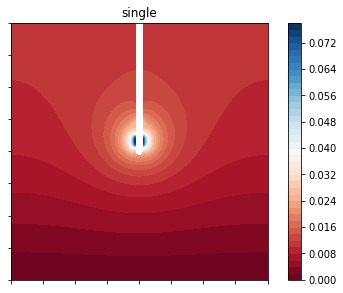

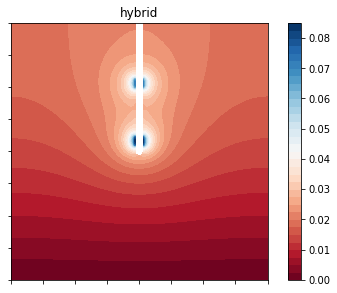

<Figure size 432x288 with 0 Axes>

In [10]:
for u_name in ['single', 'hybrid']:
    u = eval('U_'+u_name)[0]
    
    m=plot(u,cmap='RdBu')
    plt.colorbar(m)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig('./results/'+u_name+'.png', dpi=300, bbox_inches='tight')
    plt.title(u_name)
    plt.show();
    plt.clf()

In the lowe plot, the lower stimulaiton is voltage-controlled whereas the upper one is current-controlled. Cool!

## Post-processing
Let's also have a look at the floating potentials, total currents, and mean voltages.

In [11]:
Is = {'single':{}, 'hybrid':{}}
Vs = {'single':{}, 'hybrid':{}}
for u_name in ['single', 'hybrid']:
    u = eval('U_'+u_name)[0]
    # post-processing: currents
    Is[u_name]['I_0'] = abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(cnt_id+0)))
    Is[u_name]['I_1'] = abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(cnt_id+1)))
    Is[u_name]['I_2'] = abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(cnt_id+2)))
    Is[u_name]['I_3'] = abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(cnt_id+3)))
    Is[u_name]['I_bottom'] = abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(3)))
    
    Vs[u_name]['V_0'] = assemble(u*ds(cnt_id+0))/assemble(dot(n,n)*ds(cnt_id+0))
    Vs[u_name]['V_1'] = assemble(u*ds(cnt_id+1))/assemble(dot(n,n)*ds(cnt_id+1))
    Vs[u_name]['V_2'] = assemble(u*ds(cnt_id+2))/assemble(dot(n,n)*ds(cnt_id+2))
    Vs[u_name]['V_3'] = assemble(u*ds(cnt_id+3))/assemble(dot(n,n)*ds(cnt_id+3))
    Vs[u_name]['V_bottom'] = assemble(u*ds(3))/assemble(dot(n,n)*ds(3))

### Floating potentials

In [12]:
for u_name in ['single', 'hybrid']:
    print(u_name)
    u = eval('U_'+u_name)
    for i in [1,2,3,4]:
        print('floating potential value on C{} = {:.5E}'.format(i-1, u[i].vector()[0]))
    print('\n')

single
floating potential value on C0 = NAN
floating potential value on C1 = 9.23879E-02
floating potential value on C2 = NAN
floating potential value on C3 = 3.61312E-02


hybrid
floating potential value on C0 = NAN
floating potential value on C1 = 5.92789E-02
floating potential value on C2 = NAN
floating potential value on C3 = 7.78727E-01




There is no floating potential for C0 and C2 as we know their value already. 

### Currents and mean voltages

In [13]:
for name in Is.keys():
    print(name)
    for edge in ['0','1','2','3','bottom']:
        print(edge+'\tCurrent: {:.5E}\t\tMean voltage: {:.5E}'.format(Is[name]['I_'+edge],
                                                              Vs[name]['V_'+edge]))
    print('\n')

single
0	Current: 2.45883E-09		Mean voltage: 7.23075E-02
1	Current: 4.19329E-09		Mean voltage: 2.43573E-02
2	Current: 7.77759E-10		Mean voltage: 1.38913E-02
3	Current: 7.95752E-10		Mean voltage: 1.36903E-02
bottom	Current: 1.99369E-10		Mean voltage: 0.00000E+00


hybrid
0	Current: 2.44045E-09		Mean voltage: 7.90390E-02
1	Current: 1.55914E-09		Mean voltage: 3.14261E-02
2	Current: 1.76620E-09		Mean voltage: 2.79644E-02
3	Current: 2.52554E-08		Mean voltage: 6.83640E-02
bottom	Current: 1.82604E-10		Mean voltage: 0.00000E+00




Note the mean voltage of on the surface of C0 and C2. Their value has dropeed significantly due to the interface. That's why the DBS community decided to switch to current-control stimulation.

## An important note about the convergence of currents
Note that in hybrid case, the current at C3 is not equal to the prescribed value of `1e-12`. Why is that? 

This is due to the low quality of mesh that causes *leakage* of charge near the sharpe edges. We can see that more clearly by plotting the gradient of the solution which is proportional to the current on the surfaces).

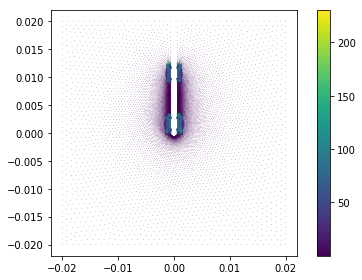

In [16]:
# if you want to investigate it better, use Qt backende by uncommenting 
# the its import on top. You may need to restart the kernel
m=plot(-grad(U_hybrid[0]))
plt.colorbar(m)
plt.tight_layout()
plt.savefig('./results/grads.png', dpi=300, bbox_inches='tight')

The large vectors show very high gradient (degeneracies) which occur very close to the borders of a contact. Our mesh does not have a high quality. In a real-world scenario, one has to check if the solution of the FEM is mesh dependent or not (usually by refinement). Here, however, as we wanted to merely compare the eFEM with VP, we skipped it.